In [171]:
import numpy as np
import ot
from ot.datasets import make_1D_gauss
import pandas as pd
import matplotlib.pyplot as plt
from utils.Visualizations import *
from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider
import ipywidgets as widgets
import seaborn as sns
from tqdm import tqdm
from scipy.stats import norm, sem, t
import time

In [3]:
def create_distribs_and_costs(res, noise, scale_parameter=1, distance_metric='L1', first_center = 0.35, first_std = 0.1, 
                              second_center = 0.65, second_std = 0.1):
    X = np.linspace(0,scale_parameter,res)
    p = norm.pdf(X, scale_parameter * first_center, scale_parameter * first_std)
    p = p/p.sum()
    q = norm.pdf(X, scale_parameter * second_center, scale_parameter * second_std)
    q = q/q.sum()
    
    C = np.zeros([res, res], dtype=np.float64)
    if distance_metric == 'L1':
        dist = lambda a, b: abs(a - b)
    elif distance_metric == 'L2':
        dist = lambda a, b: (a - b) ** 2
    else:
        raise ValueError('Invalid distance metric. Must be either "L1" or "L2".')
    for it1 in range(res):
        for it2 in range(res):
            C[it1, it2] = dist(X[it1], X[it2])

    noise_p = np.random.normal(0, noise, res)
    noise_q = np.random.normal(0, noise, res)

    p_noised = p + noise_p
    q_noised = q + noise_q

    p_pos, p_neg = split_signed_measure(p_noised)
    q_pos, q_neg = split_signed_measure(q_noised)

    p_post = p_pos + q_neg
    q_post = p_neg + q_pos

    mean_distribs = (q_post.sum() + p_post.sum()) / 2
    p_post = p_post * (mean_distribs / p_post.sum())
    q_post = q_post * (mean_distribs / q_post.sum())
    
    return p, q, p_post, q_post, C

In [4]:
def confidence_interval(data, confidence=0.96):
    # Compute the sample mean
    mean = np.mean(data)
    
    # Compute the standard error of the mean
    std_err = sem(data)
    
    # Get the degrees of freedom and lookup the t-value
    dof = len(data) - 1
    t_val = t.ppf((1 + confidence) / 2, dof)
    
    # Compute the margin of error
    margin_error = t_val * std_err
    
    return mean, margin_error

In [5]:
def run_experiment_and_append(df, res, noise_param, scale_param, reg_m_param=10):
    results_classic = []
    results_noised = []
    ratios_emd = []
    results_linear = []
    results_linear_noised = []
    ratios_linear = []
    diff_classics = []
    diff_posts = []

    for i in range(100):
        p, q, p_post, q_post, C = create_distribs_and_costs(res, noise_param, scale_param)

        results_classic_add = calc_transport_pot_emd(p, q, C)[1]
        plan_noised, results_noised_add = calc_transport_pot_emd(p_post, q_post, C)

        results_classic.append(results_classic_add)
        results_noised.append(results_noised_add)
        ratios_emd.append(results_classic_add / results_noised_add)

        cumsum_p = np.cumsum(p)
        cumsum_q = np.cumsum(q)
        diff_classic = np.abs(cumsum_p - cumsum_q)
        diff_classics.append(diff_classic.sum())

        cumsum_p_post = np.cumsum(p_post)
        cumsum_q_post = np.cumsum(q_post)
        diff_post = np.abs(cumsum_p_post - cumsum_q_post)
        diff_posts.append(diff_post.sum())

        results_linear.append(np.linalg.norm(p - q))
        results_linear_noised.append(np.linalg.norm(p_post - q_post))
        ratios_linear.append(np.linalg.norm(p - q) / np.linalg.norm(p_post - q_post))

    mean_classic, ci_classic = confidence_interval(results_classic)
    mean_noised, ci_noised = confidence_interval(results_noised)
    # Create new row
    new_row = {
        'Res': res,
        'Noise_Param': noise_param,
        'Scale_Param': scale_param,
        'Distances_Classic': mean_classic,
        'CI_Distances_Classic': ci_classic,
        'Distances_Noised': mean_noised,
        'CI_Distances_Noised': ci_noised,
        'Cumsum_Classic': np.mean(diff_classics),
        'Cumsum_Noised': np.mean(diff_posts),
        'Ratios_emd_cumsum': np.mean(results_noised) / np.mean(diff_posts),
        'Ratios_EMD': np.mean(ratios_emd),
        'Distances_Linear': np.mean(results_linear),
        'Distances_Linear_Noised': np.mean(results_linear_noised),
        'Ratios_Linear': np.mean(ratios_linear)
    }

    # Append new row to DataFrame
    return df._append(new_row, ignore_index=True)

## CI for measures

In [148]:
columns = ['Res', 'Noise_Param', 'Scale_Param', 'Distances_Classic', 'CI_Distances_Classic',
           'Distances_Noised', 'CI_Distances_Noised',
           'Cumsum_Classic', 'Cumsum_Noised', 'Ratios_emd_cumsum',
           'Ratios_EMD', 'Distances_Linear', 'Distances_Linear_Noised', 'Ratios_Linear']
df = pd.DataFrame(columns=columns)

In [149]:
resolution =200
scale_param = 200
X = np.linspace(0,scale_param,resolution)
noises = np.logspace(start=-3,stop=1, num=22)

In [150]:
for noise in tqdm(noises):
    df = run_experiment_and_append(df, res=resolution, noise_param=noise, scale_param=scale_param)

 ... (more hidden) ...C:\Users\eriki\AppData\Local\Temp\ipykernel_8032\304085810.py:56: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return df._append(new_row, ignore_index=True)
 ... (more hidden) ...


ValueError: x and y must have same first dimension, but have shapes (22,) and (10,)

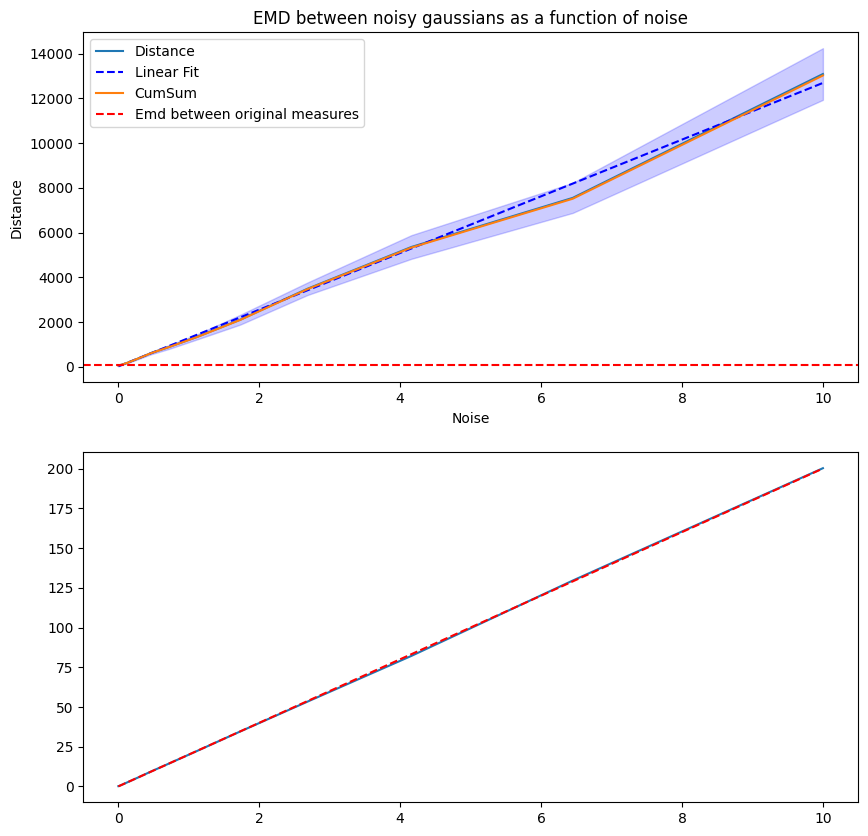

In [151]:
x = df['Noise_Param']
y = df['Distances_Noised']

# Compute the linear fit parameters (slope and y-intercept)
slope, intercept = np.polyfit(x, y, 1)
y_fit = slope * x + intercept

fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(2,1,1)
# Plot the distances
ax1.plot(x, y, label='Distance')
# Fill between for confidence intervals for Distances_Noised
ax1.fill_between(x, 
                 y - df['CI_Distances_Noised'], 
                 y + df['CI_Distances_Noised'], 
                 color='b', alpha=0.2) # light blue shading for confidence interval

# Plot the linear fit line
ax1.plot(x, y_fit, 'b--', label='Linear Fit')
# ax1.set_xscale('log') # Uncomment if you want to set x-axis to logarithmic scale
ax1.plot(df['Noise_Param'], df['Cumsum_Noised'], label='CumSum')
ax1.set_title('EMD between noisy gaussians as a function of noise')
ax1.set_xlabel('Noise')
ax1.set_ylabel('Distance')
ax1.axhline(y=df['Distances_Classic'][0], color='r', linestyle='--', label='Emd between original measures')
ax1.legend()


# For Distances_Linear_Noised
ax3 = fig.add_subplot(2,1,2)
y_linear_noised = df['Distances_Linear_Noised']
slope_linear_noised, intercept_linear_noised = np.polyfit(x, y_linear_noised, 1)
y_fit_linear_noised = slope_linear_noised * x + intercept_linear_noised

ax3.plot(x, y_linear_noised, label='Distances_Linear_Noised')
#ax3.fill_between(x, 
#                 y_linear_noised - df['CI_Distances_Linear_Noised'], 
#                 y_linear_noised + df['CI_Distances_Linear_Noised'], 
#                 color='orange', alpha=0.2)
ax3.plot(x, y_fit_linear_noised, 'r--', label='Linear Fit (Linear Noised)')
ax3.plot(df['Noise_Param'], approx_distances, 'k-.', label='2*noise*sqrt(chi-squared) Approximation')
ax3.set_title('Linear distances between noisy images as a function of noise')
ax3.set_xlabel('Noise')
ax3.set_ylabel('Distance')
ax3.legend()

plt.tight_layout()
plt.show()

## Images

In [64]:
def run_experiment_and_append_images(df, im1, im2, noise_param, n_samples=100):
    results_classic = []
    results_noised = []
    ratios_emd = []
    results_linear = []
    results_linear_noised = []
    ratios_linear = []
    diff_classics = []
    diff_posts = []

    for i in range(n_samples):
        im1_post, im2_post, C = create_images_and_costs(im1_base=im1, im2_base=im2, noise=noise_param)

        results_classic_add = calc_transport_pot_emd(im1.flatten(), im2.flatten(), C)[1]
        results_noised_add = calc_transport_pot_emd(im1_post.flatten(), im2_post.flatten(), C)[1]

        results_classic.append(results_classic_add)
        results_noised.append(results_noised_add)
        ratios_emd.append(results_classic_add / results_noised_add)

        results_linear.append(np.linalg.norm(im1 - im2))
        results_linear_noised.append(np.linalg.norm(im1_post - im2_post))
        ratios_linear.append(np.linalg.norm(im1 - im2) / np.linalg.norm(im1_post - im2_post))

    mean_noised, ci_noised = confidence_interval(results_noised)
    mean_linear_noised, ci_linear_noised = confidence_interval(results_linear_noised)


    new_row = {
        'Noise_Param': noise_param,
        'Distances_Classic': np.mean(results_classic),
        'Distances_Noised': mean_noised,
        'CI_Distances_Noised': ci_noised,
        'Ratios_EMD': np.mean(ratios_emd),
        'Distances_Linear': np.mean(results_linear),
        'Distances_Linear_Noised': mean_linear_noised,
        'CI_Distances_Linear_Noised': ci_linear_noised,
        'Ratios_Linear': np.mean(ratios_linear)
    }

    # Append new row to DataFrame
    return df._append(new_row, ignore_index=True)

In [65]:
im1 = np.zeros([10,10])
im1[1:3,1:3] = 1
im2 = np.zeros([10,10])
im2[7:9,7:9] = 1

In [66]:
columns = ['Noise_Param', 'Distances_Classic', 'Distances_Noised', 'CI_Distances_Noised', 'Ratios_EMD', 
           'Distances_Linear', 'Distances_Linear_Noised', 'CI_Distances_Linear_Noised', 'Ratios_Linear']
df = pd.DataFrame(columns=columns)

noises = np.linspace(start=1e-3,stop=1, num=10)    

In [67]:
for noise in tqdm(noises):
    df = run_experiment_and_append_images(df, im1, im2, noise)

  0%|                                                                                              | 0/10 [00:00<?, ?it/s]C:\Users\eriki\AppData\Local\Temp\ipykernel_8032\365647846.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return df._append(new_row, ignore_index=True)
100%|█████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.47it/s]


In [69]:
df.head()

,Noise_Param,Distances_Classic,Distances_Noised,CI_Distances_Noised,Ratios_EMD,Distances_Linear,Distances_Linear_Noised,CI_Distances_Linear_Noised,Ratios_Linear
0,0.001,33.941125,33.980918,0.007380,0.998830,2.828427,2.828501,0.000281,0.999974
1,0.112,33.941125,38.549729,0.781660,0.889185,2.828427,3.283102,0.029601,0.863112
2,0.223,33.941125,42.462373,1.524048,0.823914,2.828427,4.224316,0.055443,0.672199
3,0.334,33.941125,48.194135,1.991375,0.732553,2.828427,5.463072,0.079402,0.520306
4,0.445,33.941125,54.751165,2.358273,0.645028,2.828427,6.928821,0.100252,0.410198


In [76]:
M, N = im1.shape  # replace this with the shape of your images
degrees_of_freedom = M * N
expected_chi2 = degrees_of_freedom
approx_distances = 2 * df['Noise_Param'] * np.sqrt(expected_chi2)

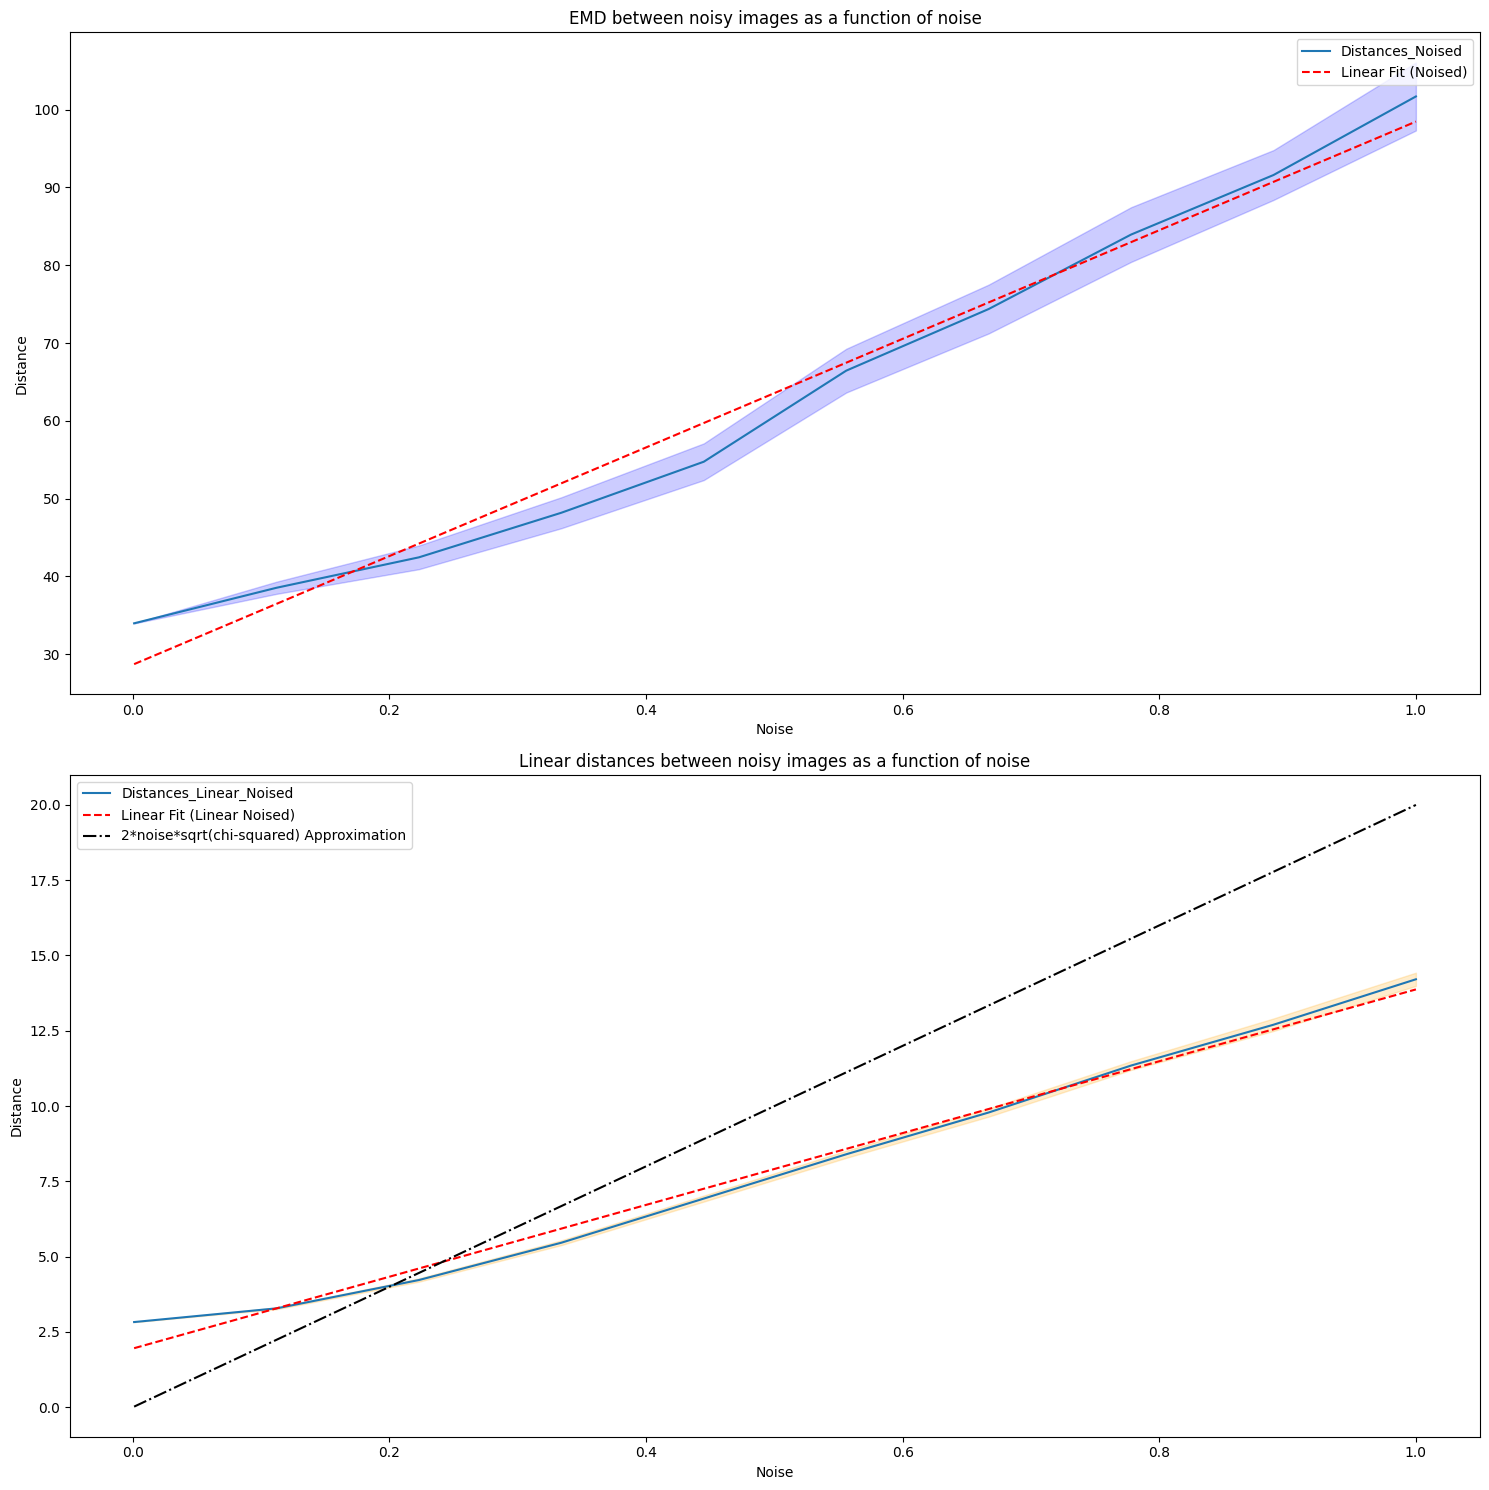

In [77]:
fig = plt.figure(figsize=(15,15))

# For Distances_Noised
ax1 = fig.add_subplot(2,1,1)
x = df['Noise_Param']
y_noised = df['Distances_Noised']
slope_noised, intercept_noised = np.polyfit(x, y_noised, 1)
y_fit_noised = slope_noised * x + intercept_noised

ax1.plot(x, y_noised, label='Distances_Noised')
ax1.fill_between(x, 
                 y_noised - df['CI_Distances_Noised'], 
                 y_noised + df['CI_Distances_Noised'], 
                 color='b', alpha=0.2)
ax1.plot(x, y_fit_noised, 'r--', label='Linear Fit (Noised)')
ax1.set_title('EMD between noisy images as a function of noise')
ax1.set_xlabel('Noise')
ax1.set_ylabel('Distance')
ax1.legend()

# For Distances_Linear_Noised
ax3 = fig.add_subplot(2,1,2)
y_linear_noised = df['Distances_Linear_Noised']
slope_linear_noised, intercept_linear_noised = np.polyfit(x, y_linear_noised, 1)
y_fit_linear_noised = slope_linear_noised * x + intercept_linear_noised

ax3.plot(x, y_linear_noised, label='Distances_Linear_Noised')
ax3.fill_between(x, 
                 y_linear_noised - df['CI_Distances_Linear_Noised'], 
                 y_linear_noised + df['CI_Distances_Linear_Noised'], 
                 color='orange', alpha=0.2)
ax3.plot(x, y_fit_linear_noised, 'r--', label='Linear Fit (Linear Noised)')
ax3.plot(df['Noise_Param'], approx_distances, 'k-.', label='2*noise*sqrt(chi-squared) Approximation')
ax3.set_title('Linear distances between noisy images as a function of noise')
ax3.set_xlabel('Noise')
ax3.set_ylabel('Distance')
ax3.legend()

plt.tight_layout()
plt.show()

In [78]:
slope_linear_noised

11.925380650225923

In [79]:
black_slope, black_intercept = np.polyfit(df['Noise_Param'], approx_distances, 1)

In [80]:
black_slope

20.000000000000004

## W(p,p')
Trying to understand the effect of noising a single measure and whats the difference between this single measure and its noised option, the noised measure will be normalized.

In [11]:
res = 500
noise = 1e-3
scale = 100
noises = np.logspace(start=-3,stop=1, num=22)

In [3]:
p, q, p_post, q_post, C = create_distribs_and_costs(res=res, noise=noise, scale_parameter=scale)

In [4]:
noise_p = np.random.normal(0, noise, res)
p_noised = p + noise_p

In [5]:
p_noised_pos, p_noised_neg = split_signed_measure(p_noised)

In [6]:
p_added_neg = p + p_noised_neg

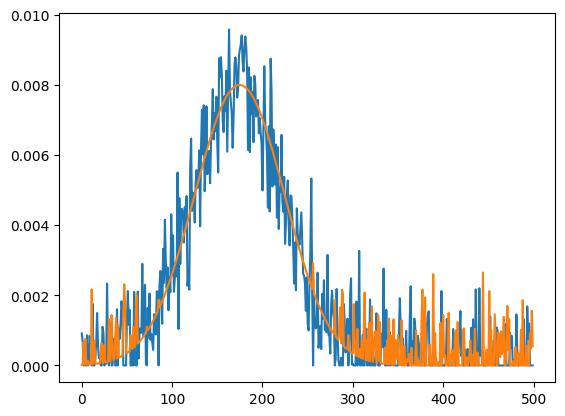

In [7]:
plt.plot(p_noised_pos)
plt.plot(p_added_neg)

In [8]:
p_new = p_added_neg / p_added_neg.sum()
p_noised_new = p_noised_pos / p_noised_pos.sum()

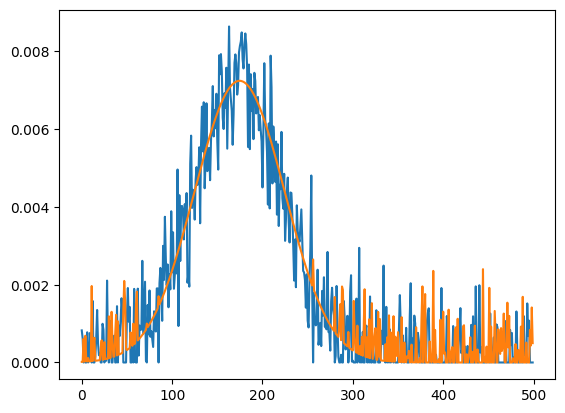

In [9]:
plt.plot(p_noised_new)
plt.plot(p_new)

In [186]:
distances = []
start = time.time()
for noise in tqdm(noises):
    
    results = []
    
    for i in range(100):
        noise_p = np.random.normal(0, noise, res)
        p_noised = p + noise_p
        p_noised_pos, p_noised_neg = split_signed_measure(p_noised)
        p_added_neg = p + p_noised_neg

        mean_distribs = (p_added_neg.sum() + p_noised_pos.sum())/2
        p_new = p_added_neg * (mean_distribs / p_added_neg.sum())
        p_noised_new = p_noised_pos * (mean_distribs / p_noised_pos.sum())

        
        result = calc_transport_pot_emd(p_new, p_noised_new, C)[1]
        results.append(result)

    
    distances.append(np.mean(results))
end = time.time()
print(f'elapsed time is {end - start}')

100%|█████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:30<00:00,  1.37s/it]

elapsed time is 30.1269690990448


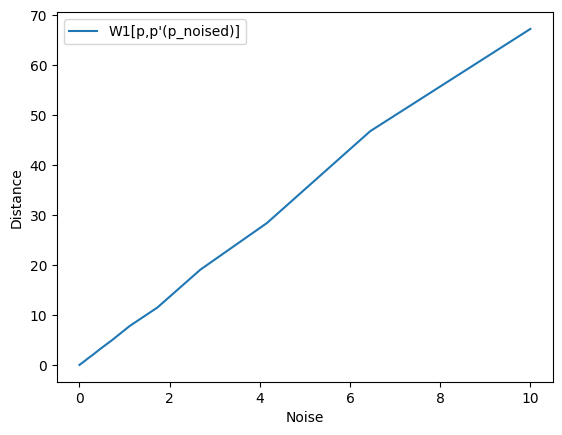

In [187]:
plt.plot(noises, distances, label="W1[p,p'(p_noised)]")
plt.xlabel('Noise')
plt.ylabel('Distance')
plt.legend()

In [188]:
columns = ['Res', 'Noise_Param', 'Scale_Param', 'Distances_Classic', 'CI_Distances_Classic',
           'Distances_Noised', 'CI_Distances_Noised',
           'Cumsum_Classic', 'Cumsum_Noised', 'Ratios_emd_cumsum',
           'Ratios_EMD', 'Distances_Linear', 'Distances_Linear_Noised', 'Ratios_Linear']
df = pd.DataFrame(columns=columns)

In [193]:
df = pd.read_csv('results_measures.csv')

In [198]:
res = 500
scale_param = 100
X = np.linspace(0,scale_param,res)
p = create_distribs_and_costs(res=res, noise=noise, scale_parameter=scale)[0]
noises = np.logspace(start=-3, stop=1, num=22)
partial_df = df[(df['Res'] == res) & (df['Scale_Param'] == scale_param)]

In [201]:
x = partial_df['Noise_Param']
y = partial_df['Distances_Noised']

In [199]:
y2 = partial_df['Distances_Classic']

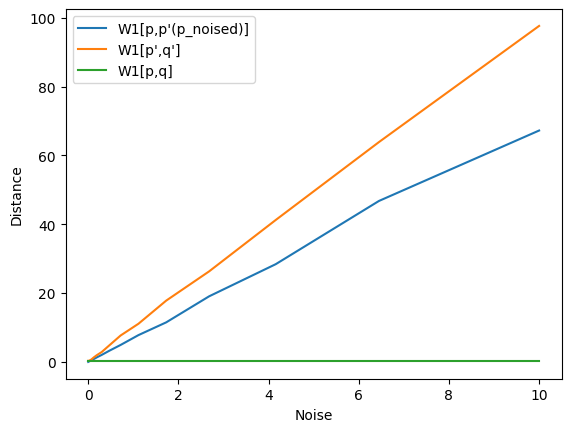

In [202]:
plt.plot(x, distances, label="W1[p,p'(p_noised)]")
plt.plot(x, y, label="W1[p',q']")
plt.plot(x, y2, label="W1[p,q]")
plt.xlabel('Noise')
plt.ylabel('Distance')
plt.legend()

In [207]:
noises = df['Noise_Param'].unique()

In [219]:
df_new_subset = df[(df['Res']==100) & (df['Noise_Param'] == noises[21])]

In [220]:
scale_times_noise = df_new_subset['Scale_Param'] * df_new_subset['Noise_Param']
scale_times_noise = scale_times_noise.sort_values()

In [221]:
len(df_new_subset['Distances_Noised'])

4

Text(0, 0.5, 'Distances')

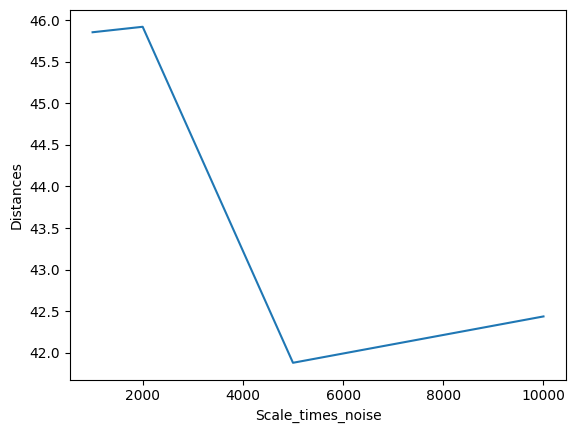

In [222]:
plt.plot(scale_times_noise, df_new_subset['Distances_Noised'], label='Linearity of scale*noise')
plt.xlabel('Scale_times_noise')
plt.ylabel('Distances')

In [153]:
slope, intercept = np.polyfit(noises, distances, 1)

In [154]:
slope

730.5621645658248

In [155]:
np.sqrt(slope)

27.028913492144387

## Looking into the slopes as a function of res,scale and the cost matrix

In [224]:
columns = ['Res', 'Noise_Param', 'Scale_Param', 'Distances_Classic', 'Distances_Noised',
           'Ratios_EMD', 'Distances_Linear', 'Distances_Linear_Noised', 'Ratios_Linear']
df2 = pd.DataFrame(columns=columns)

# TODO : add original distance as a parameter and column

res_values = [100, 200, 500, 1000]
noise_values = np.logspace(start=-3, stop=1, num=22)  # We want a multiplication of 3 + 1 because we start at 0
scale_values = [100, 200, 500, 1000]

for res in res_values:
    for noise in noise_values:
        for scale in scale_values:
            df2 = run_experiment_and_append(df2, res=res, noise_param=noise, scale_param=scale)
    print('Done with res: ', res)

C:\Users\eriki\OneDrive\Documents\all_folder\Thesis\Thesis\utils\utils.py:505: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return df._append(new_row, ignore_index=True)


Done with res:  100
Done with res:  200
Done with res:  500
Done with res:  1000


In [235]:
df2.to_csv('results_measures_notebook.csv', index=False)

In [225]:
new_df_columns = ['Res', 'Scale_Param', 'Slope', 'Intercept', 'Distance']
new_df = pd.DataFrame()

In [226]:
unique_res = df2['Res'].unique()
unique_scale = df2['Scale_Param'].unique()

In [227]:
for i, res_option in enumerate(unique_res):
    for j, scale_option in enumerate(unique_scale):
        
        filtered_df = df2[(df2['Res'] == res_option) & (df2['Scale_Param'] == scale_option)]

        slope, intercept = np.polyfit(noises, filtered_df['Distances_Noised'], 1)
        
        new_row = {
            'Res' : res_option,
            'Scale_Param' : scale_option,
            'Slope' : slope,
            'Intercept' : intercept,
            'Distance': filtered_df['Distances_Noised'].values
        }

        new_df = new_df._append(new_row, ignore_index=True)

In [228]:
new_df.head()

,Res,Scale_Param,Slope,Intercept,Distance
0,100.0,100.0,4.129103,0.351131,"[0.2996898464771892, 0.30039019716983517, 0.30..."
1,100.0,200.0,4.659743,0.057272,"[0.3003502809004001, 0.30095402502448687, 0.30..."
2,100.0,500.0,4.355204,0.230474,"[0.3000309054062517, 0.3006085217651154, 0.302..."
3,100.0,1000.0,4.537994,0.175440,"[0.29940592364770696, 0.30098001733653723, 0.3..."
4,200.0,100.0,6.195460,0.200817,"[0.3000751861833844, 0.299743855447624, 0.3009..."


In [229]:
len(new_df.index)

16

Text(0, 0.5, 'Slope')

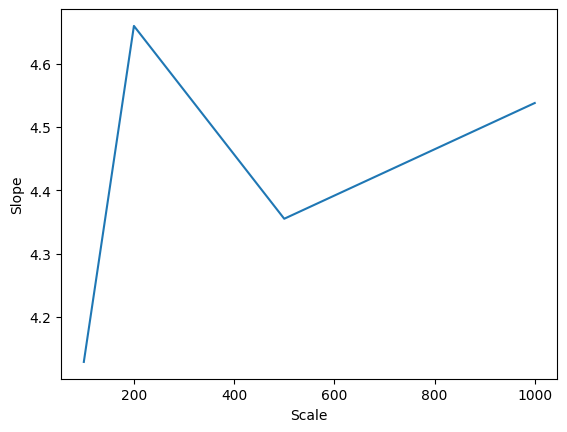

In [230]:
curr_df = new_df[new_df['Res'] == 100]
plt.plot(curr_df['Scale_Param'], curr_df['Slope'])  # X first, Y second
plt.xlabel('Scale')
plt.ylabel('Slope')

Text(0, 0.5, 'Slope')

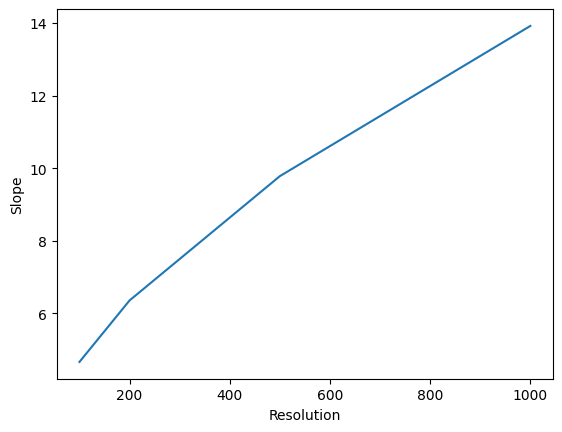

In [231]:
curr_df = new_df[new_df['Scale_Param'] == 200]
plt.plot(curr_df['Res'], curr_df['Slope'])  # X first, Y second
plt.xlabel('Resolution')
plt.ylabel('Slope')

In [232]:
curr_df.head()

,Res,Scale_Param,Slope,Intercept,Distance
1,100.0,200.0,4.659743,0.057272,"[0.3003502809004001, 0.30095402502448687, 0.30..."
5,200.0,200.0,6.354246,0.216331,"[0.29987645752581077, 0.30109554491119134, 0.3..."
9,500.0,200.0,9.780420,0.169596,"[0.2991148363600053, 0.3030960358827079, 0.302..."
13,1000.0,200.0,13.921609,0.051998,"[0.30097827561224905, 0.3035117239330962, 0.29..."


In [233]:
curr_df['Distance'][0]

KeyError: 0

In [223]:
distances = curr_df['Distance'].reset_index(inplace=True)

TypeError: Cannot reset_index inplace on a Series to create a DataFrame

In [164]:
distances

,index,Distance
0,1,"[0.3002613886789609, 0.3009901427436187, 0.302..."
1,5,"[0.300991358104622, 0.3010484188684393, 0.3062..."
2,9,"[0.3021536262316502, 0.3019749767611855, 0.303..."
3,13,"[0.3014991565627719, 0.3016635452646356, 0.304..."


ValueError: setting an array element with a sequence.

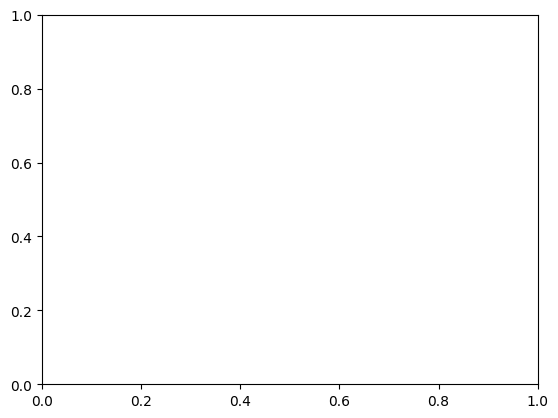

In [98]:
curr_df = new_df[new_df['Res'] == 500]

plt.plot(curr_df['Scale_Param'], curr_df['Distance'])  # X first, Y second
plt.xlabel('Scale')
plt.ylabel('Slope')